In [75]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    InputXGradient,
    Saliency,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
import transform_wrappers
import visualize as viz
from model import Net, Net2c
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from acd_wooseok.acd.scores import cd
from acd_wooseok.acd.util import tiling_2d
from acd_wooseok.acd.scores import score_funcs
from torchvision import datasets, transforms
# import modules
from funcs import *
from matfac import *
sys.path.append('../../..')
from hierarchical_dnn_interpretations.acd.scores import cd as acd

# Dataset

In [77]:
# load args
args = dset.get_args()
args.batch_size = int(args.batch_size/2) # half the batchsize
args.epochs = 50
args.cuda = not args.no_cuda and torch.cuda.is_available()

# load mnist dataloader
train_loader, test_loader = dset.load_data_with_indices(args.batch_size, args.test_batch_size, device)

# dataset
X = train_loader.dataset.data.numpy().astype(np.float32)
X = X.reshape(X.shape[0], -1)
X /= 255
Y = train_loader.dataset.targets.numpy()

X_test = test_loader.dataset.data.numpy().astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], -1)
X_test /= 255
Y_test = test_loader.dataset.targets.numpy()

# load NMF object
# run NMF
# nmf = NMF(n_components=30, max_iter=1000)
# nmf.fit(X)
# pkl.dump(nmf, open('./results/nmf_30.pkl', 'wb'))
nmf = pkl.load(open('./results/nmf_30.pkl', 'rb'))
D = nmf.components_
# nmf transform
W = nmf.transform(X) 
W_test = nmf.transform(X_test) 

# Load model

In [78]:
dict_indx = 1
model = Net2c().to(device)
model.load_state_dict(torch.load('models/nmf/net2c_{}.pth'.format(dict_indx), map_location=device))
model = model.eval()

# knockout first dictionary and redefine train and test dataset
indx = np.argwhere(W[:,dict_indx] > 0).flatten()
indx_t = np.argwhere(W_test[:,dict_indx] > 0).flatten()

# subset dataloader
train_loader, test_loader = dset.load_data_with_indices(args.batch_size,
                                                        args.test_batch_size,
                                                        device,
                                                        subset_index=[indx, indx_t])

# Score NMF basis

In [79]:
# network with transform augmented
transform = transform_wrappers.lay_from_w(D)
norm = transform_wrappers.NormLayer(mu=0.1307, std=0.3081)
reshape = transform_wrappers.ReshapeLayer(shape=(1, 28, 28))
net = transform_wrappers.Net_with_transform(model, 
                                            transform=transform, 
                                            norm=norm, 
                                            reshape=reshape,
                                            use_logits=True).to(device)

In [80]:
# convert nmf weight to tensor
W_test_t = torch.Tensor(W_test)

# interp modules
gradient_shap = GradientShap(net)
ig = IntegratedGradients(net)
saliency = Saliency(net)
input_x_gradient = InputXGradient(net)

# store results
results = {
    'gradient_shap': [],
    'ig': [],
    'saliency': [],
    'input_x_gradient': []
}
for batch_indx, (data, target, data_indx) in enumerate(test_loader):
    # loop over nmf basis
    x_t = W_test_t[data_indx].to(device).requires_grad_(True)
    # comp gradient
    baselines = torch.zeros_like(x_t)
    results['gradient_shap'].append(gradient_shap.attribute(x_t, baselines=baselines, target=0).cpu().detach().numpy())
    results['ig'].append(ig.attribute(x_t, target=0).cpu().detach().numpy())
    results['saliency'].append(saliency.attribute(x_t, target=0, abs=False).cpu().detach().numpy())
    results['input_x_gradient'].append(input_x_gradient.attribute(x_t, target=0).cpu().detach().numpy())

    print('\r batch index: {}'.format(batch_indx), end='')  

results['gradient_shap'] = np.vstack(results['gradient_shap'])
results['ig'] = np.vstack(results['ig'])
results['saliency'] = np.vstack(results['saliency'])
results['input_x_gradient'] = np.vstack(results['input_x_gradient'])


 batch index: 3

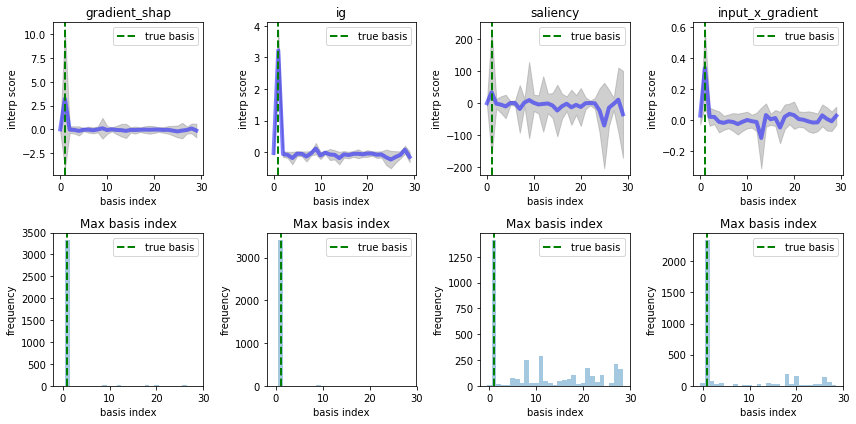

In [81]:
list_of_x = np.arange(nmf.n_components)
interp_modules = ['gradient_shap', 'ig', 'saliency', 'input_x_gradient']

i = 0
plt.figure(figsize=(12, 6))
for c in range(4):
    plt.subplot(2, 4, i + 1)
    plt.plot(list_of_x, results[interp_modules[i]].mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
    plt.fill_between(list_of_x, results[interp_modules[i]].mean(axis=0)-results[interp_modules[i]].std(axis=0), 
                results[interp_modules[i]].mean(axis=0)+results[interp_modules[i]].std(axis=0), color='#888888', alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('interp score')
    plt.title(interp_modules[i])
    
    plt.subplot(2, 4, i + 5)
    plt.hist(np.argmax(results[interp_modules[i]],axis=1), bins=list_of_x-0.5, alpha=0.4)
    plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
    plt.legend()
    plt.xlabel('basis index')
    plt.ylabel('frequency')
    plt.title('Max basis index')    
    i += 1
plt.tight_layout()
plt.show()

## grad*basis 

In [82]:
# nmf transform layers
nmf_transformer = transform_wrappers.TransformLayers(D).to(device)

# # convert nmf weight to tensor
W_test_t = torch.Tensor(W_test).to(device)
sweep_dim = 1
tiles = torch.Tensor(tiling_2d.gen_tiles(W_test[0:1], fill=0, method='cd', sweep_dim=sweep_dim)).to(device)

# interp modules
saliency = Saliency(model)
ig = IntegratedGradients(model)

# store results
results['dot_product'] = []

for batch_indx, (data, target, data_indx) in enumerate(test_loader):
    # set requires_grad 
    data = data.to(device).requires_grad_(True)
    # comp gradient
    attribution = saliency.attribute(data, target=0, abs=False)
    # loop over nmf basis
    scores = []
    for basis_indx in range(nmf.n_components):
        im_parts = nmf_transformer(W_test_t[data_indx]*tiles[basis_indx])
        scores.append(torch.sum(attribution * im_parts, axis=(1,2,3)).cpu().detach().numpy())
        
        print('\r batch index: {} [component index: {}]'.format(batch_indx, basis_indx), end='')  
        
    scores = np.vstack(scores).T
    results['dot_product'].append(scores)
results['dot_product'] = np.vstack(results['dot_product'])

 batch index: 3 [component index: 29]

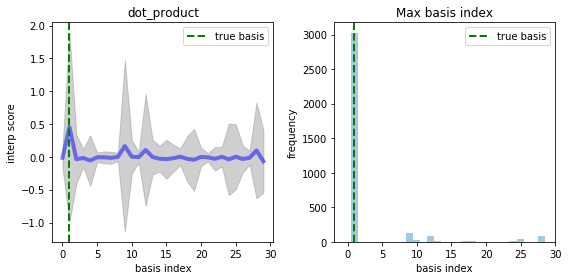

In [83]:
list_of_x = np.arange(nmf.n_components)
interp_modules += ['dot_product']

i = 4
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(list_of_x, results[interp_modules[i]].mean(axis=0), alpha=0.5, color='blue', linewidth=4.0)
plt.fill_between(list_of_x, results[interp_modules[i]].mean(axis=0)-results[interp_modules[i]].std(axis=0), 
            results[interp_modules[i]].mean(axis=0)+results[interp_modules[i]].std(axis=0), color='#888888', alpha=0.4)
plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
plt.legend()
plt.xlabel('basis index')
plt.ylabel('interp score')
plt.title(interp_modules[i])

plt.subplot(1, 2, 2)
plt.hist(np.argmax(results[interp_modules[i]],axis=1), bins=list_of_x-0.5, alpha=0.4)
plt.axvline(x=dict_indx, linestyle='--', color='green', label='true basis', linewidth=2.0)
plt.legend()
plt.xlabel('basis index')
plt.ylabel('frequency')
plt.title('Max basis index')    
plt.tight_layout()
plt.show()